In [1]:
%pylab notebook
import datetime
import numpy as np
import pandas as pd
import os

from cognite import CogniteClient

Populating the interactive namespace from numpy and matplotlib


In [2]:
client = CogniteClient(api_key=os.environ['PUBLICDATA_API_KEY'])

# Introduction
As an illustration, let us consider the task of **smoothing** a time series:
elminating irregularities due to noise while preserving the greater trend.
We will use the winding termperature of a gear on Valhall, which is sufficiently noisy.

In [4]:
ts_of_interest = 'VAL_23-KA-9101-M01_Winding_Temperature_W1:VALUE'
start = datetime.datetime(2018, 8, 13)
end = start + datetime.timedelta(days=1)

df = client.datapoints.get_datapoints_frame(
    time_series=[ts_of_interest],
    start=start,
    end=end,
    granularity='1m',
    aggregates=['avg']
)
df.columns = ['timestamp', 'temp']

In [5]:
@np.vectorize
def ts2dt(ts): return datetime.datetime.fromtimestamp(ts/1000)

df.timestamp = ts2dt(df.timestamp)
df.index = df.timestamp
df = df.drop(['timestamp'], axis=1)

<IPython.core.display.Javascript object>


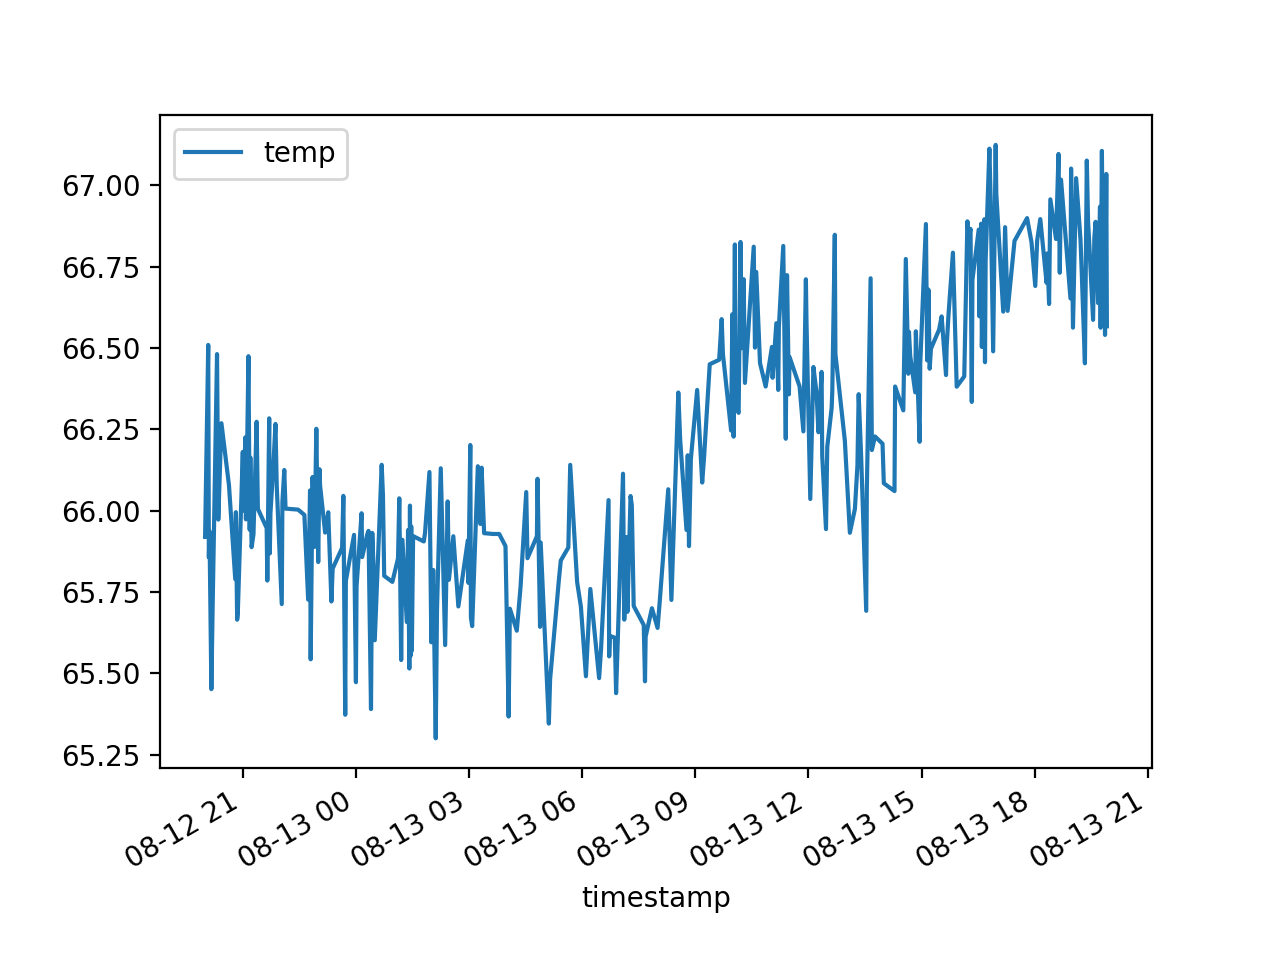

In [7]:
df.plot.line()

# Observations
Plotting the time series (see above), we notice that it is indeed quite noisy.
Decreasing the granularity, we could get rid of this noise (implicitly smoothing by averaging),
but high granularity might be desirable (e.g. for a model training input).

# Investigation
Let us apply LOWESS smoothing to the data with varying values of the `frac` parameter,
which denotes the fraction of all data considered to lie within a datum's neighborhood.
Visual inspection will let us determine the best looking fit: the sweet spot in the bias/variance tradeoff.

In [9]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [13]:
fractions = [1, 2, 3, 5, 10, 20, 30, 50]
for f in fractions:
    df['temp_smooth_%d' % f] = lowess(df.temp, df.index, frac=f/100, is_sorted=True)[:, 1]

<IPython.core.display.Javascript object>


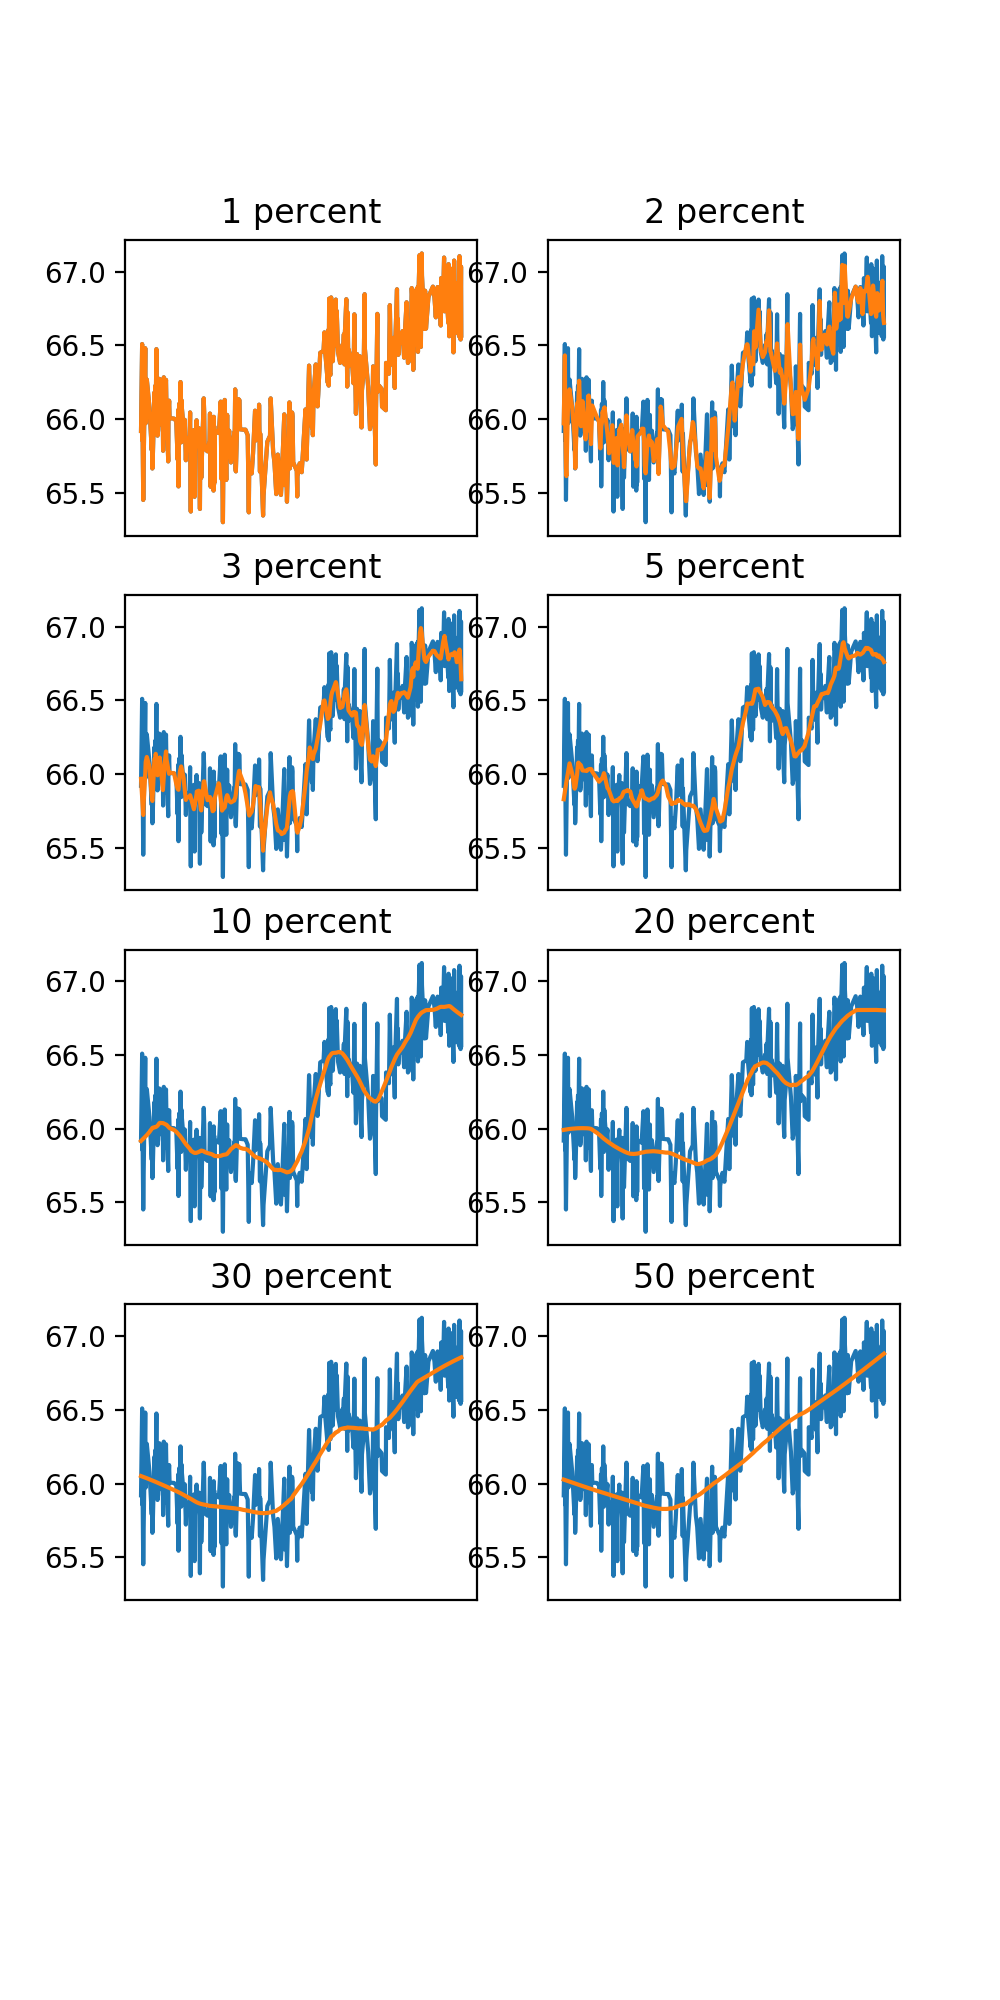

In [14]:
fig, ax = plt.subplots((len(fractions)+1)//2, 2, figsize=(5, 10))
for i, col in enumerate(fractions):
    axis = ax[i//2][i%2]
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    df.plot.line(y=['temp', 'temp_smooth_%d' % col],
                 ax=axis, legend=False, title = '%d percent' % col)

# Analysis

It appears that the best smoothing results from a value of `frac` in the neighborhood of `0.1`.
Let us study this neighborhood more closely.

In [16]:
fractions = range(5, 15)
for f in fractions:
    df['temp_smooth_%d' % f] = lowess(df.temp, df.index, frac=f/100, is_sorted=True)[:, 1]

<IPython.core.display.Javascript object>


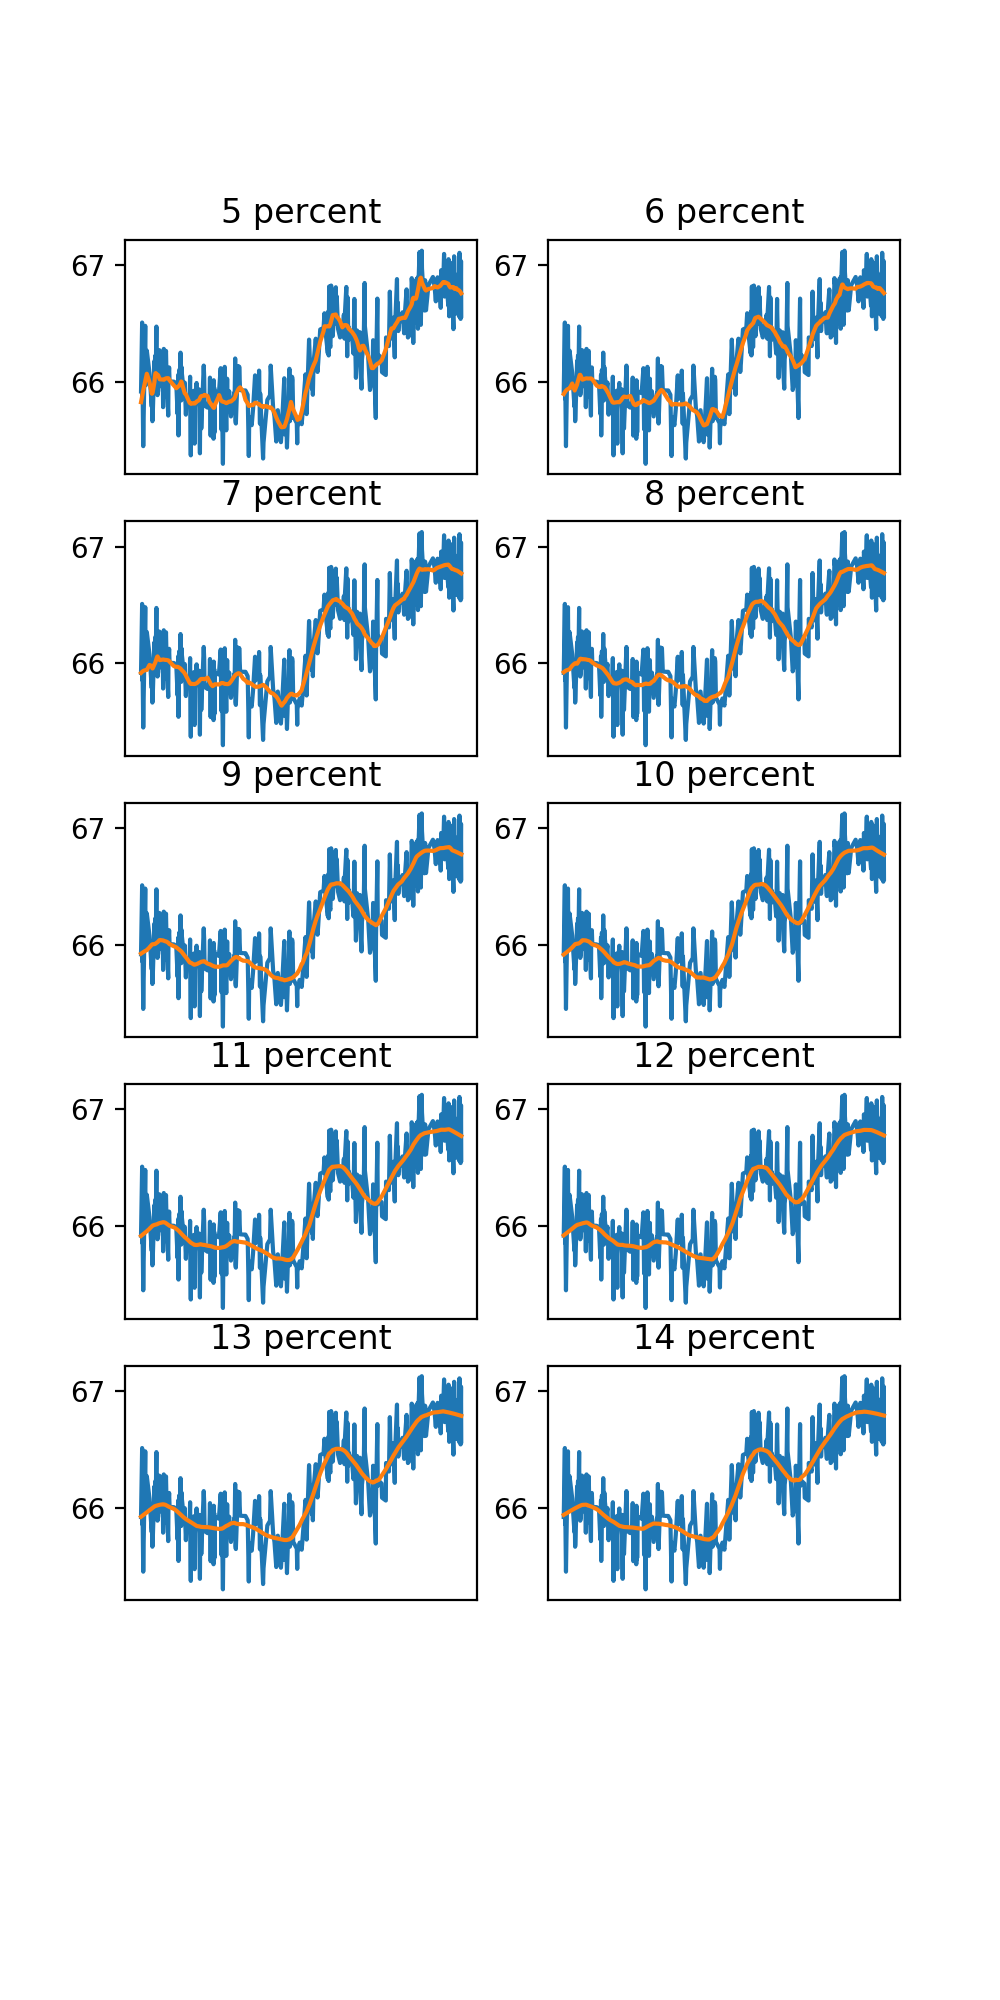

In [26]:
fig, ax = plt.subplots((len(fractions)+1)//2, 2, figsize=(5, 10))
for i, col in enumerate(fractions):
    axis = ax[i//2][i%2]
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    df.plot.line(y=['temp', 'temp_smooth_%d' % col],
                 ax=axis, legend=False, title = '%d percent' % col)

# Analysis

It is less obvious here which value works best here.
In general, a parameter selection heuristic is our goal,
so this is comforting, in a sense: it appears that the smoothing
is not undesirably sensitive to change in `frac`.